# Liesel-GAM Demo Notebook

## Setup and Imports

In [21]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [22]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

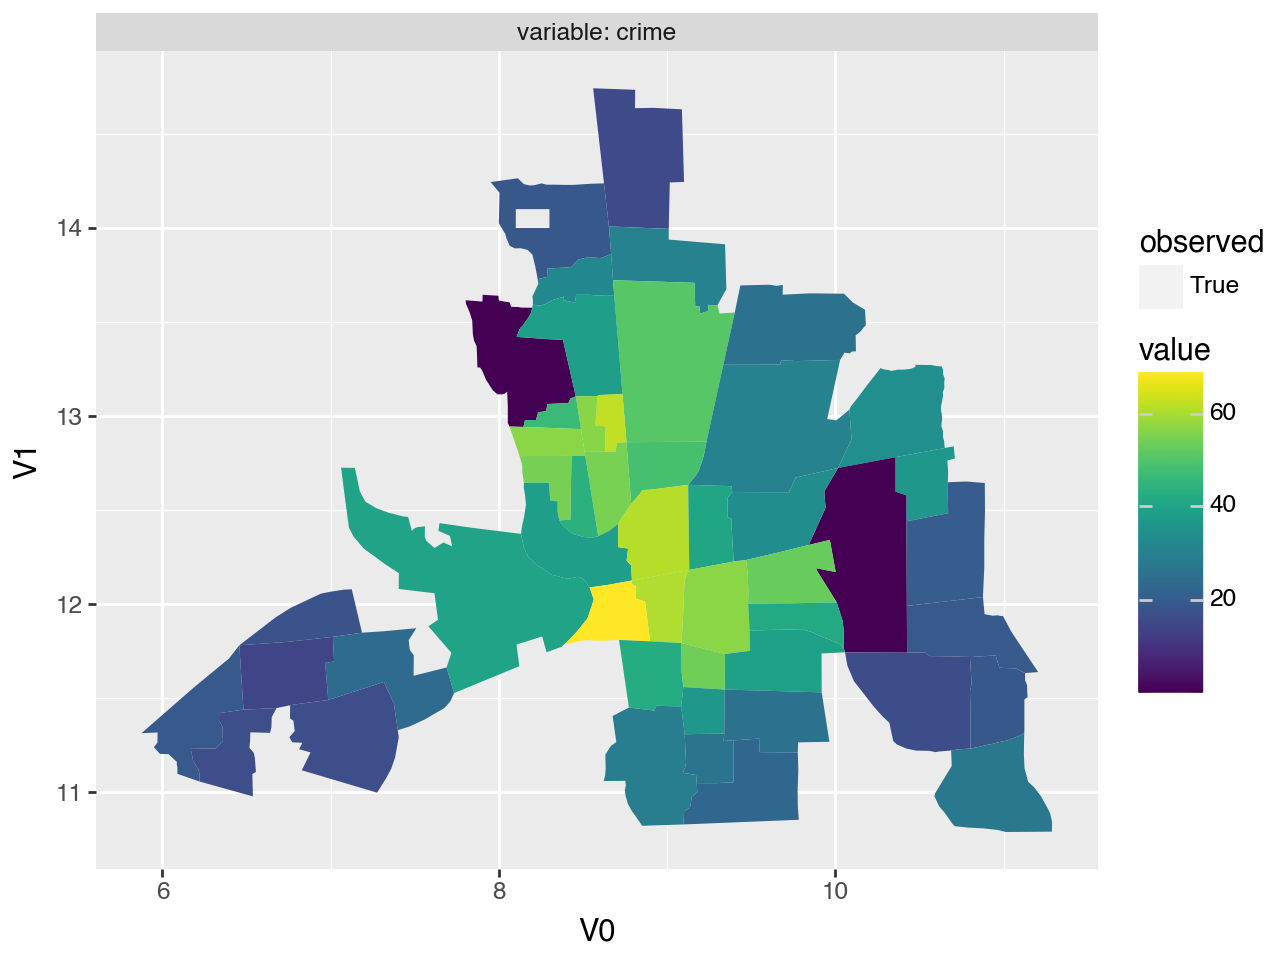

In [23]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [24]:
df = columb

# standardizing makes it easier for the model
df["crime"] = (df["crime"] - df["crime"].mean()) / df["crime"].std()

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)

# initializing intercepts to sensible values
loc.intercept.value = df.crime.mean()
scale.intercept.value = jnp.log(df.crime.std())


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.ri("district", factor_scale=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\beta_{0,\mu}$_value").value


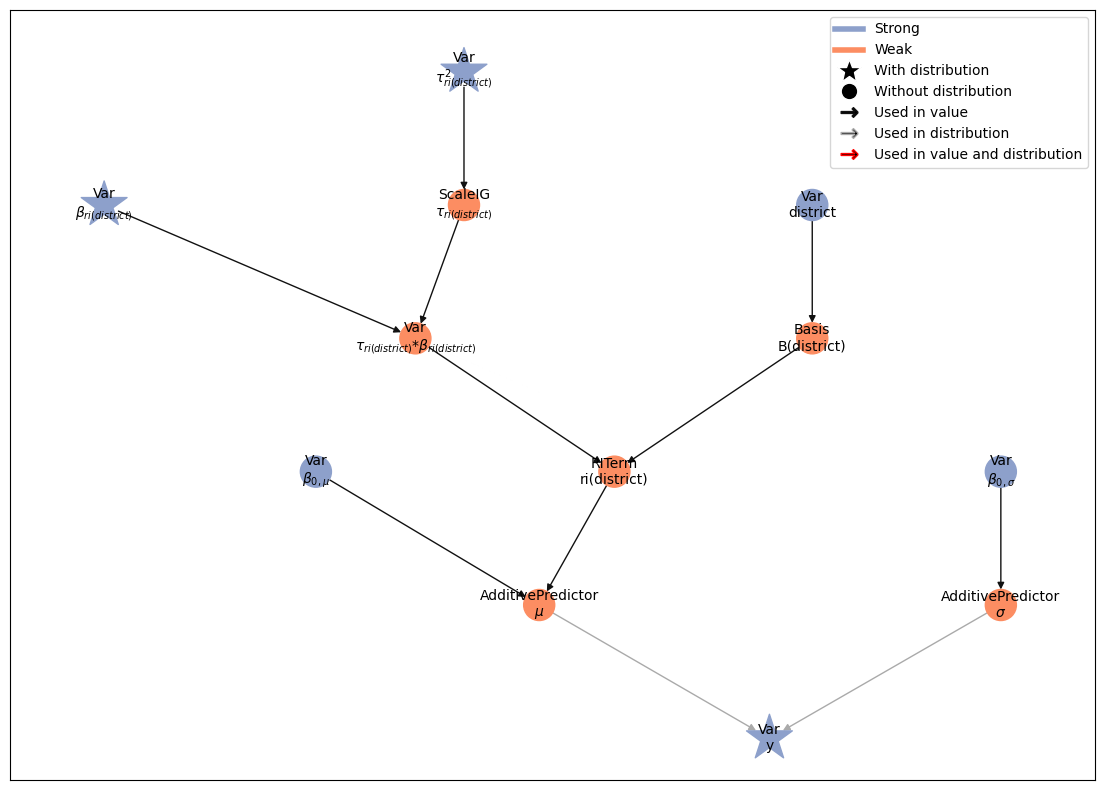

In [25]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [26]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ri(district)}$', '$\\tau_{ri(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.24chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.72chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [27]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel      mean        sd    q_0.05  \
parameter               index                                            
$\beta_{0,\mu}$         ()     kernel_01 -0.005114  0.145367 -0.243600   
$\beta_{0,\sigma}$      ()     kernel_00 -0.000040  0.107251 -0.171180   
$\beta_{ri(district)}$  (0,)   kernel_02 -0.114520  1.013351 -1.776968   
                        (1,)   kernel_02 -0.117665  1.002974 -1.791761   
                        (2,)   kernel_02 -0.019843  1.003361 -1.684396   
                        (3,)   kernel_02  0.006285  0.983708 -1.601071   
                        (4,)   kernel_02  0.090275  0.972542 -1.503284   
                        (5,)   kernel_02 -0.066115  0.999573 -1.679540   
                        (6,)   kernel_02 -0.237052  1.014906 -1.917265   
                        (7,)   kernel_02  0.022843  0.995122 -1.581131   
                        (8,)   kernel_02 -0.024984  0.979623 -1.679014   
                        (9,)   kernel_02 -0.004644  0.997477 -1.669456   
                        (10,)  kernel_02  0.187606  0.982266 -1.413700   
                        (11,)  kernel_02  0.142257  0.982789 -1.473042   
                        (12,)  kernel_02  0.057404  0.981682 -1.594380   
                        (13,)  kernel_02  0.132081  1.007395 -1.525492   
                        (14,)  kernel_02  0.103865  0.992644 -1.510785   
                        (15,)  kernel_02  0.140757  0.995787 -1.460193   
                        (16,)  kernel_02  0.029202  0.992062 -1.579299   
                        (17,)  kernel_02  0.074492  0.978627 -1.560794   
                        (18,)  kernel_02  0.124898  1.013200 -1.541736   
                        (19,)  kernel_02 -0.221489  0.993773 -1.834133   
                        (20,)  kernel_02  0.028995  0.981227 -1.580984   
                        (21,)  kernel_02 -0.024141  0.976827 -1.604377   
                        (22,)  kernel_02 -0.109212  0.993421 -1.757174   
                        (23,)  kernel_02  0.021594  1.002394 -1.596089   
                        (24,)  kernel_02  0.212803  1.000352 -1.436119   
                        (25,)  kernel_02  0.039339  1.002009 -1.645125   
                        (26,)  kernel_02  0.112780  0.981519 -1.499247   
                        (27,)  kernel_02  0.114932  1.002042 -1.583529   
                        (28,)  kernel_02  0.147575  1.004352 -1.501877   
                        (29,)  kernel_02  0.219882  0.998673 -1.397360   
                        (30,)  kernel_02 -0.116383  0.997538 -1.735624   
                        (31,)  kernel_02 -0.080508  1.002403 -1.707431   
                        (32,)  kernel_02  0.071810  0.981285 -1.546547   
                        (33,)  kernel_02 -0.087403  1.001078 -1.711038   
                        (34,)  kernel_02  0.032245  0.997768 -1.583967   
                        (35,)  kernel_02 -0.128174  0.977477 -1.788555   
                        (36,)  kernel_02  0.062274  0.992500 -1.554487   
                        (37,)  kernel_02  0.122681  0.992455 -1.533738   
                        (38,)  kernel_02 -0.077014  0.985287 -1.709078   
                        (39,)  kernel_02 -0.143057  0.997734 -1.793833   
                        (40,)  kernel_02 -0.112754  0.999094 -1.731114   
                        (41,)  kernel_02 -0.092626  0.975503 -1.706437   
                        (42,)  kernel_02  0.006991  1.000951 -1.659625   
                        (43,)  kernel_02 -0.023423  1.017520 -1.704195   
                        (44,)  kernel_02 -0.041573  0.990635 -1.635391   
                        (45,)  kernel_02 -0.128339  0.997562 -1.752092   
                        (46,)  kernel_02 -0.058310  0.991914 -1.661159   
                        (47,)  kernel_02 -0.045507  1.011601 -1.666413   
                        (48,)  kernel_02 -0.096334  0.997661 -1.726075   
$\tau_{ri(district)}^2$ ()     kernel_03  0.018002  0.0382

## Plots

In [28]:
samples = results.get_posterior_samples()

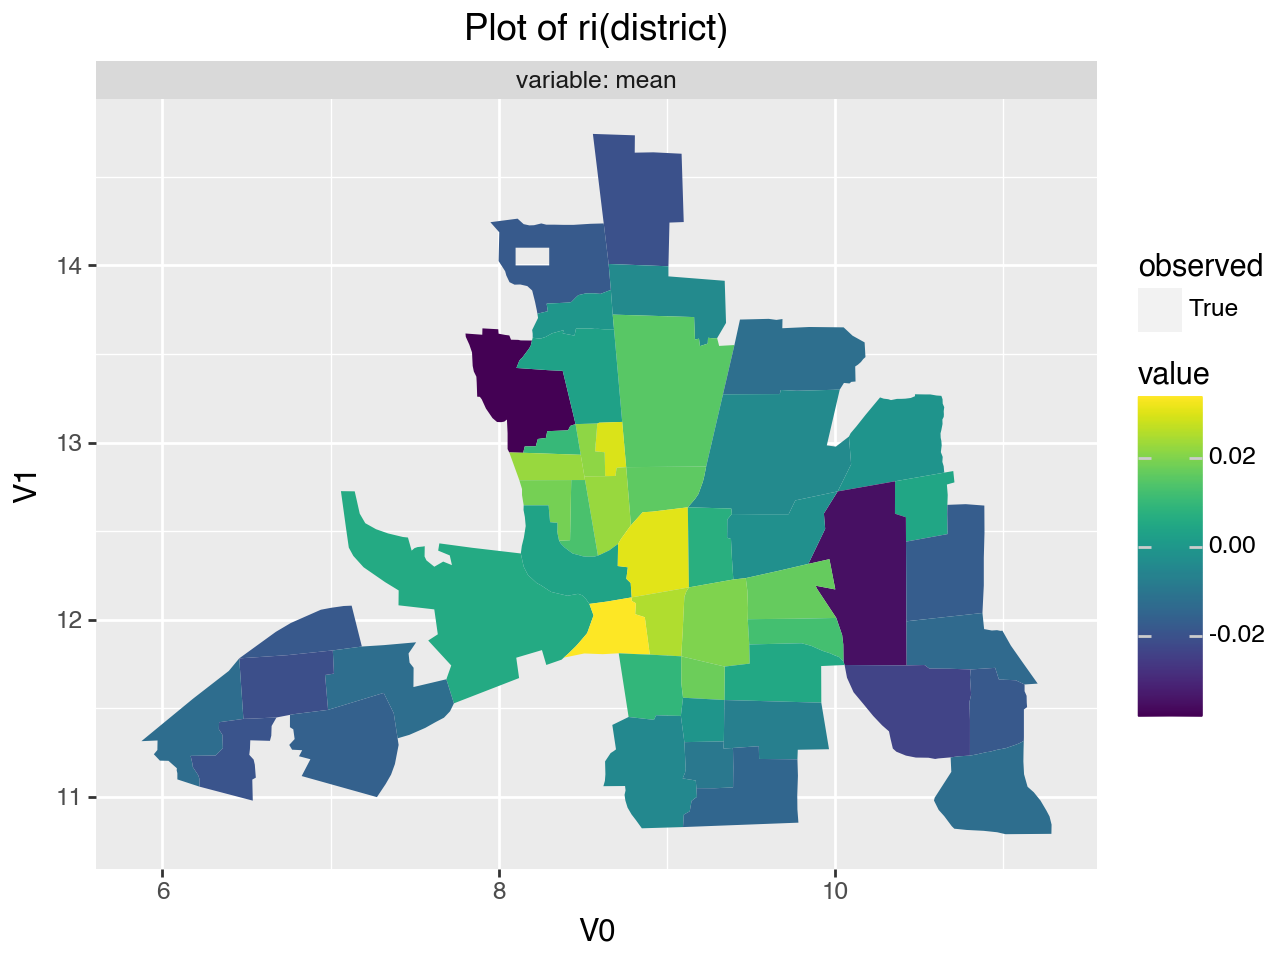

In [29]:
gam.plot_regions(term=loc.terms["ri(district)"], samples=samples, polys=polys)

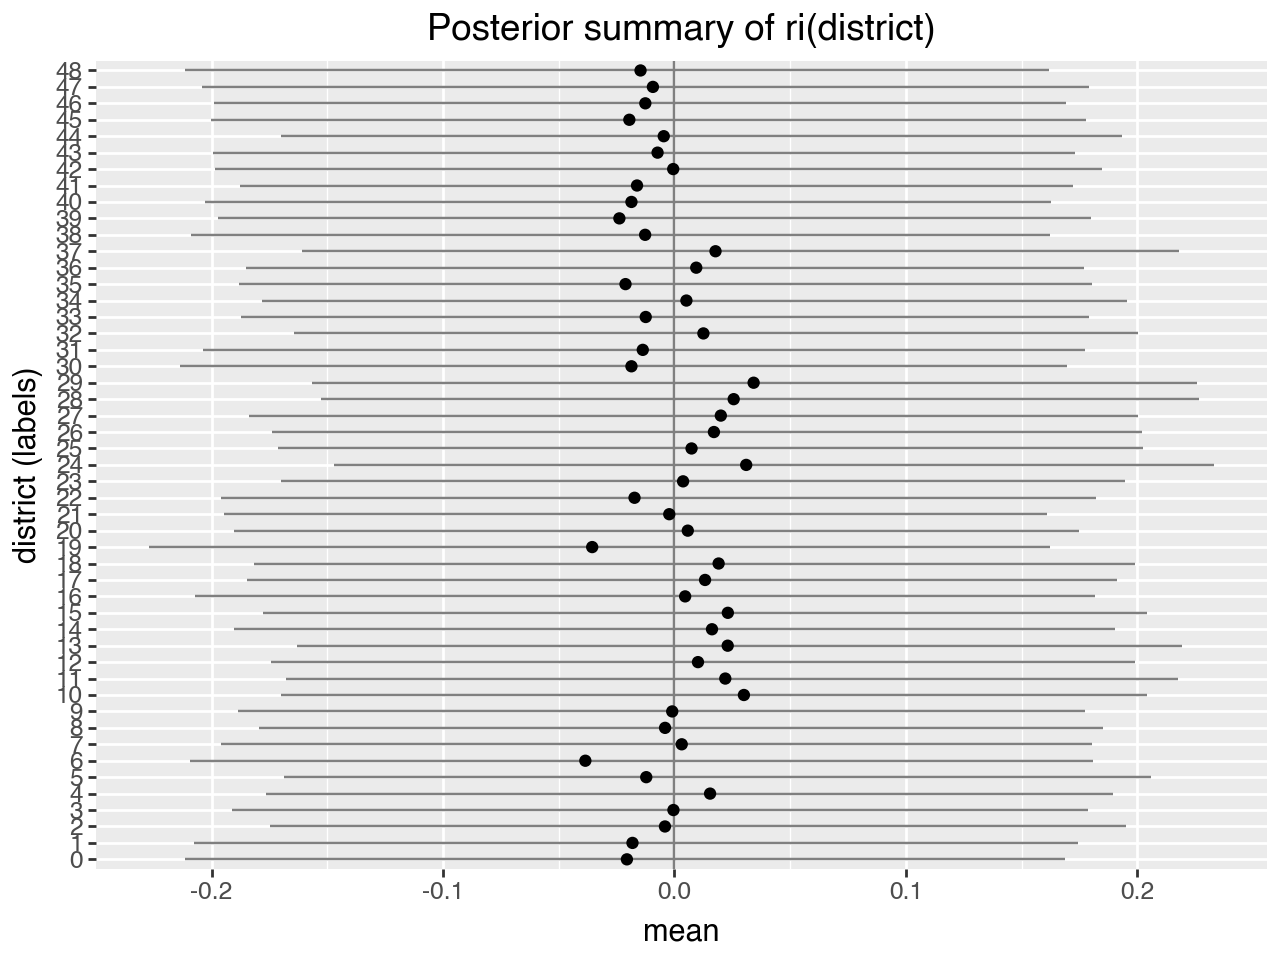

In [30]:
gam.plot_forest(
    term=loc.terms["ri(district)"],
    samples=samples,
    # labels=tb.bases.mappings["district"],
)